In [1]:
import sys
sys.path.append('/scratch/gf332/Misc/BVAE/code')

import tensorflow as tf
import tensorflow_probability as tfp

from sghmc import SGHMC
from adaptive_sghmc import AdaptiveSGHMC

import matplotlib.pyplot as plt

from tqdm import trange

tfd = tfp.distributions

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [4]:
tf.cast(tf.equal(tf.ones(5), tf.zeros(5))

<tf.Tensor: shape=(5,), dtype=bool, numpy=array([False, False, False, False, False])>

In [12]:
target_dist = tfd.MultivariateNormalTriL(loc=tf.zeros(2),
                                         scale_tril=tf.linalg.cholesky(tf.constant([[1., 0.],
                                                                                   [0.90, 1.]])))

In [24]:
sghmc = SGHMC(learning_rate=1e-3,
              data_size=1,
              momentum_decay=0.05)

adapt_sghmc = AdaptiveSGHMC(learning_rate=3e-2,
                            burnin=2000,
                            data_size=1,
                            momentum_decay=0.1)

In [25]:
theta = tf.Variable(tf.constant([-1., 4.]), name="theta")

keep_every = 5

burnin_samps = []
samples = []



for i in trange(3000):
    
    with tf.GradientTape() as tape:
        
        loss = target_dist.log_prob(theta)
        
    grads = tape.gradient(loss, (theta,))
    adapt_sghmc.apply_gradients(zip(grads, (theta,)))
    
    if any(tf.reduce_any(tf.math.is_nan(g)) for g in grads):
        print("grad was nan")
        break
    
    if i % keep_every == 0:
        if i > 2000:
            samples.append(theta.numpy())
        else:
            burnin_samps.append(theta.numpy())
        
samples = tf.stack(samples)
burnin_samps = tf.stack(burnin_samps)

100%|██████████| 3000/3000 [00:30<00:00, 99.60it/s] 


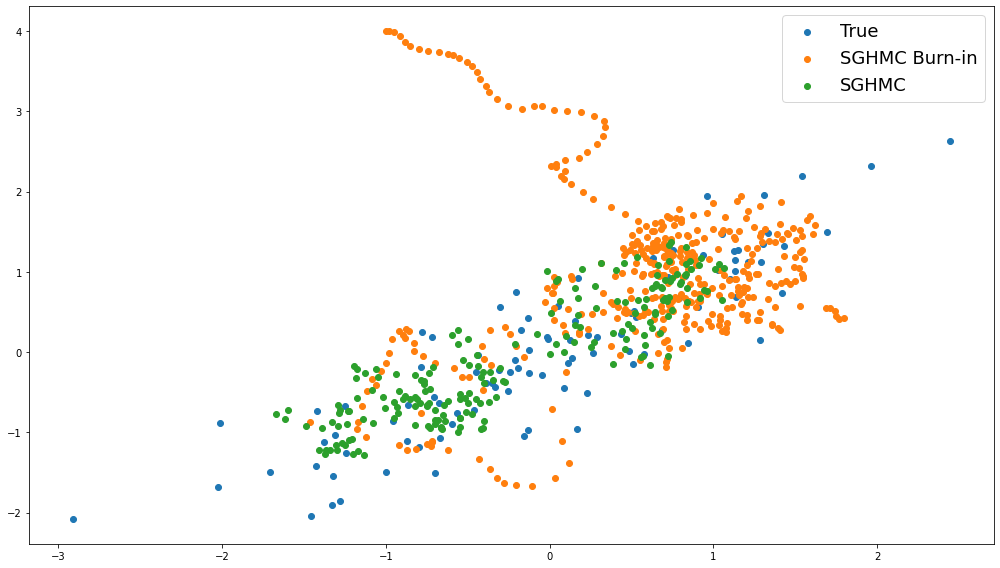

In [26]:
true_samples = target_dist.sample(100)

plt.figure(figsize=(14, 8))

plt.scatter(true_samples[:, 0], true_samples[:, 1], label="True",)
plt.scatter(burnin_samps[:, 0], burnin_samps[:, 1], label="SGHMC Burn-in")
plt.scatter(samples[:, 0], samples[:, 1], label="SGHMC")

plt.legend(fontsize=18)

plt.tight_layout()

plt.savefig("../plots/sghmc_bivariate_gaussian.png")
plt.show()

In [27]:
adapt_sghmc.variables()

[<tf.Variable 'AdaptiveSGHMC/iter:0' shape=() dtype=int64, numpy=3000>,
 <tf.Variable 'AdaptiveSGHMC/theta/momentum:0' shape=(2,) dtype=float32, numpy=array([0.00833214, 0.03802176], dtype=float32)>,
 <tf.Variable 'AdaptiveSGHMC/theta/squared_grad_magnitude:0' shape=(2,) dtype=float32, numpy=array([5.9463677, 1.3903286], dtype=float32)>,
 <tf.Variable 'AdaptiveSGHMC/theta/smoothed_gradient:0' shape=(2,) dtype=float32, numpy=array([ 2.3039615, -0.9780973], dtype=float32)>,
 <tf.Variable 'AdaptiveSGHMC/theta/exponential_average_coeff:0' shape=(2,) dtype=float32, numpy=array([1.2012101, 1.8821036], dtype=float32)>]